# Homework-Reflections. Weeks 5-8

In [1]:
# %pip install seaborn
# %pip install networkx
# %pip install --upgrade pip

In [17]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
from pathlib import Path

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from scipy.spatial.distance import mahalanobis
from numpy.linalg import inv

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars
import networkx as nx
# Scikit-learn (Machine Learning)


# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))


%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 150

## Homework Reflection. Week 5. Casual Diagrams


In [3]:
# =============================
# DAG Drawing Function
# =============================

def draw_dag_inline(edges_with_sign, title, pos=None):
    """
    edges_with_sign: list of (u, v, sign) where sign is '+' or '-'
    """
    G = nx.DiGraph()
    G.add_edges_from([(u, v) for u, v, _ in edges_with_sign])

    if pos is None:
        pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(6.5, 4.5))
    ax = plt.gca()

    # draw nodes & labels
    nx.draw_networkx_nodes(G, pos, node_color="#E3F2FD", edgecolors="#1565C0", node_size=1400, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)

    # draw edges with visible arrowheads
    nx.draw_networkx_edges(
        G, pos, ax=ax,
        arrows=True,               # make them directed
        arrowstyle='-|>',          # clear triangular head
        arrowsize=20,              # bigger heads
        width=1.8,
        connectionstyle='arc3,rad=0.0',
        min_source_margin=15,      # keep heads from hiding under nodes (NX>=2.8)
        min_target_margin=15
    )

    # optional edge labels (+/-)
    edge_labels = {(u, v): s for u, v, s in edges_with_sign}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, ax=ax)

    plt.title(title)
    plt.axis("off")
    plt.show()



### 1. Draw a diagram for the following negative feedback loop

- Sweating causes body temperature to decrease.  High body temperature causes sweating.
- A negative feedback loop means that one thing increases another while the second thing decreases the first.
- Remember that we are using directed acyclic graphs where two things cannot directly cause each other.

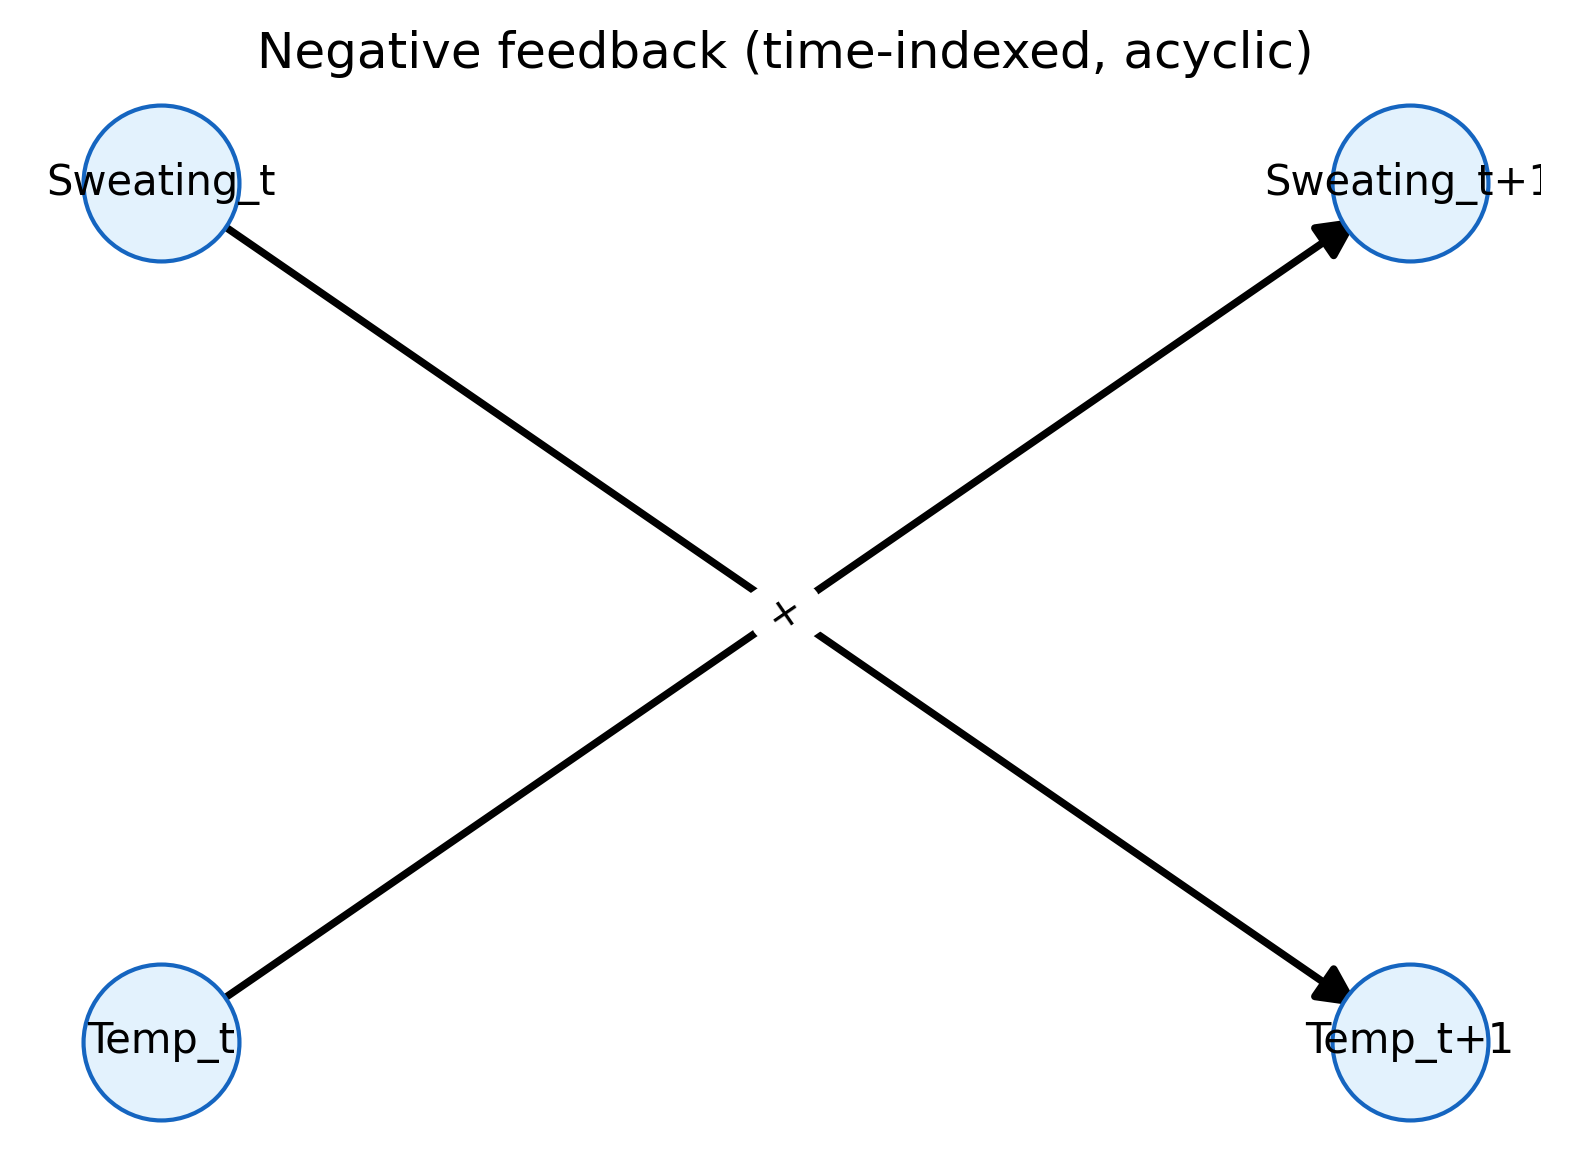

In [4]:
# =============================
# Negative feedback (time-indexed)
neg_edges = [
    ("Sweating_t", "Temp_t+1", "-"),
    ("Temp_t", "Sweating_t+1", "+"),  # "high temp causes sweating"
]
draw_dag_inline(neg_edges, "Negative feedback (time-indexed, acyclic)",
                pos={"Sweating_t": (0, 1), "Temp_t": (0, -1),
                     "Sweating_t+1": (2, 1), "Temp_t+1": (2, -1)})



Using time indexes avoids a cycle: Sweating_t -> Temp_{t+1} and Temp_t -> Sweating_{t+1}.

### 2. Describe an example of a positive feedback loop. 
This means that one things increases another while the second things also increases the first.

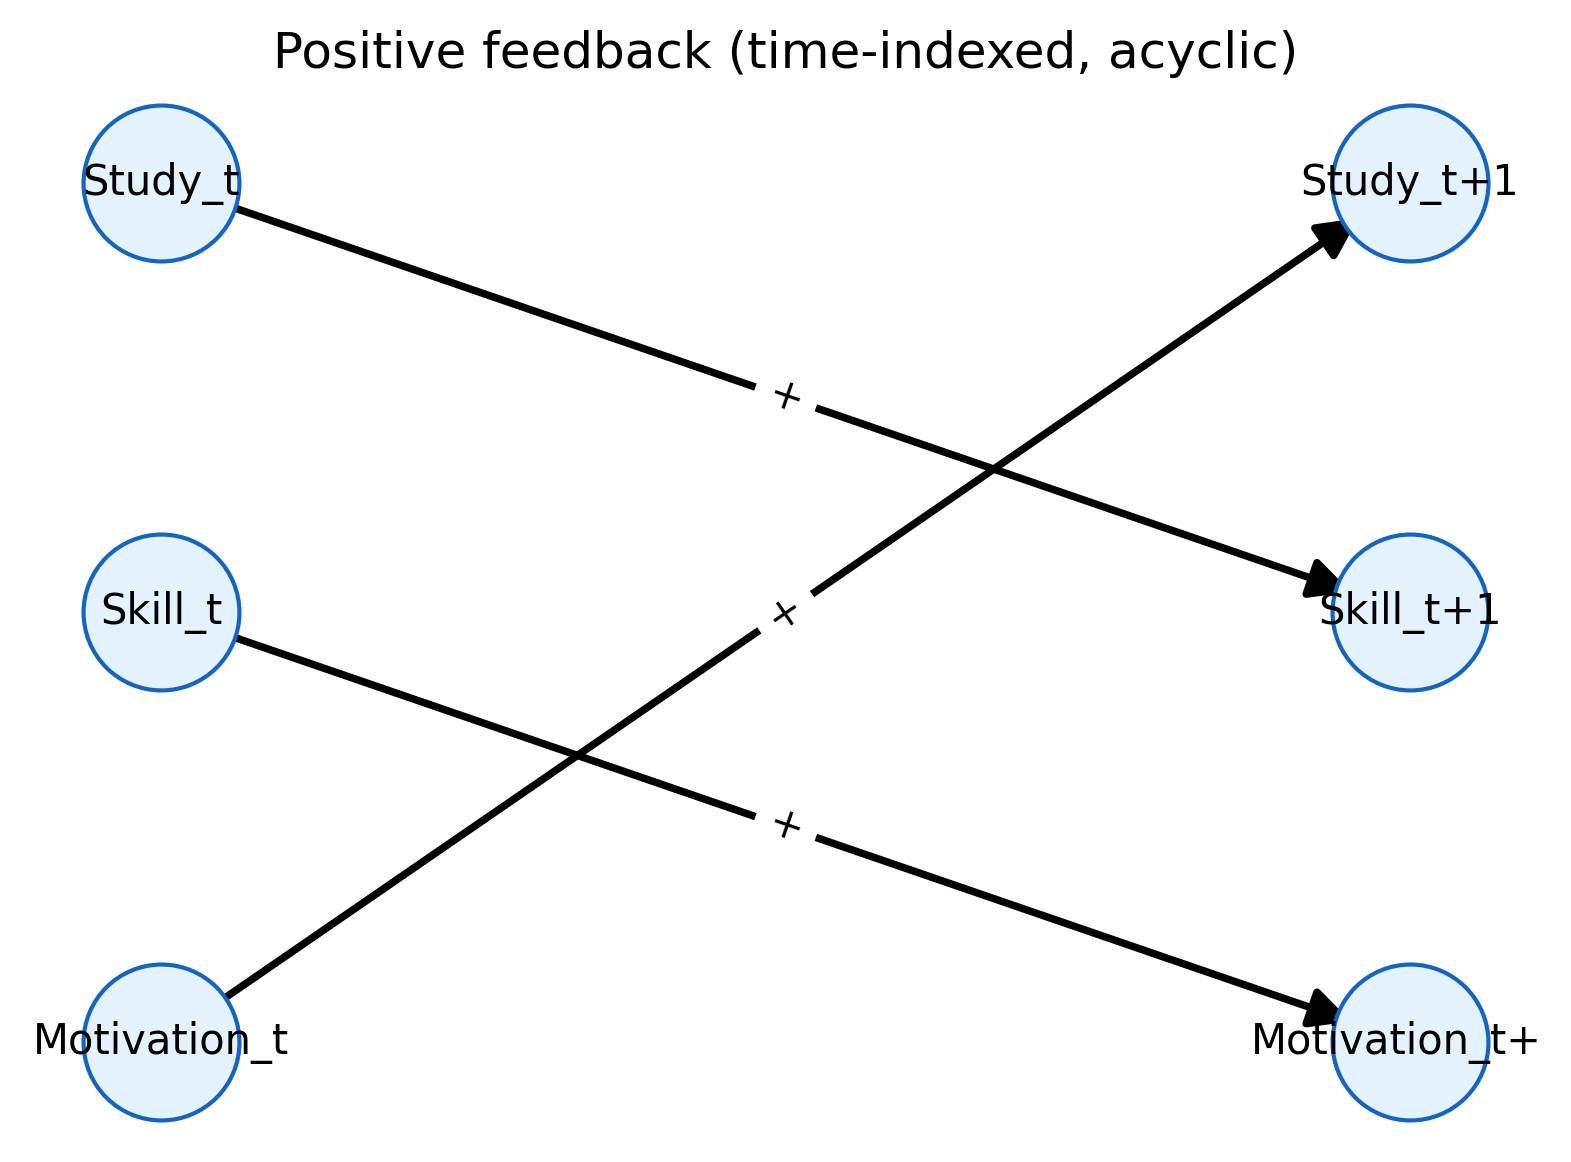

In [5]:
# =============================
# Positive feedback (time-indexed)
pos_edges = [
    ("Study_t", "Skill_t+1", "+"),
    ("Skill_t", "Motivation_t+1", "+"),
    ("Motivation_t", "Study_t+1", "+"),
]
draw_dag_inline(pos_edges, "Positive feedback (time-indexed, acyclic)",
                pos={"Study_t": (0, 1), "Skill_t": (0, 0), "Motivation_t": (0, -1),
                     "Study_t+1": (2.2, 1), "Skill_t+1": (2.2, 0), "Motivation_t+1": (2.2, -1)})


Positive feedback loop — Study -> Skill -> Motivation -> Study

When students study more, they build skill (they understand the material better). Greater skill makes tasks feel easier and more rewarding, which raises motivation. Higher motivation then leads to more study time next period. The result is a self-reinforcing cycle: small early gains compound into larger gains later.

Variables (time-indexed to avoid cycles in a DAG):
- `Study_t` -> `Skill_t+1` (more study increases next-period skill)
- `Skill_t` -> `Motivation_t+1` (higher skill boosts motivation)
- `Motivation_t` -> `Study_t+1` (motivated students study more)


### 3. Draw a diagram for the following situation

Lightning storms frighten away deer and bears, decreasing their population, and cause flowers to grow, increasing their population.
Bears eat deer, decreasing their population.
Deer eat flowers, decreasing their population.

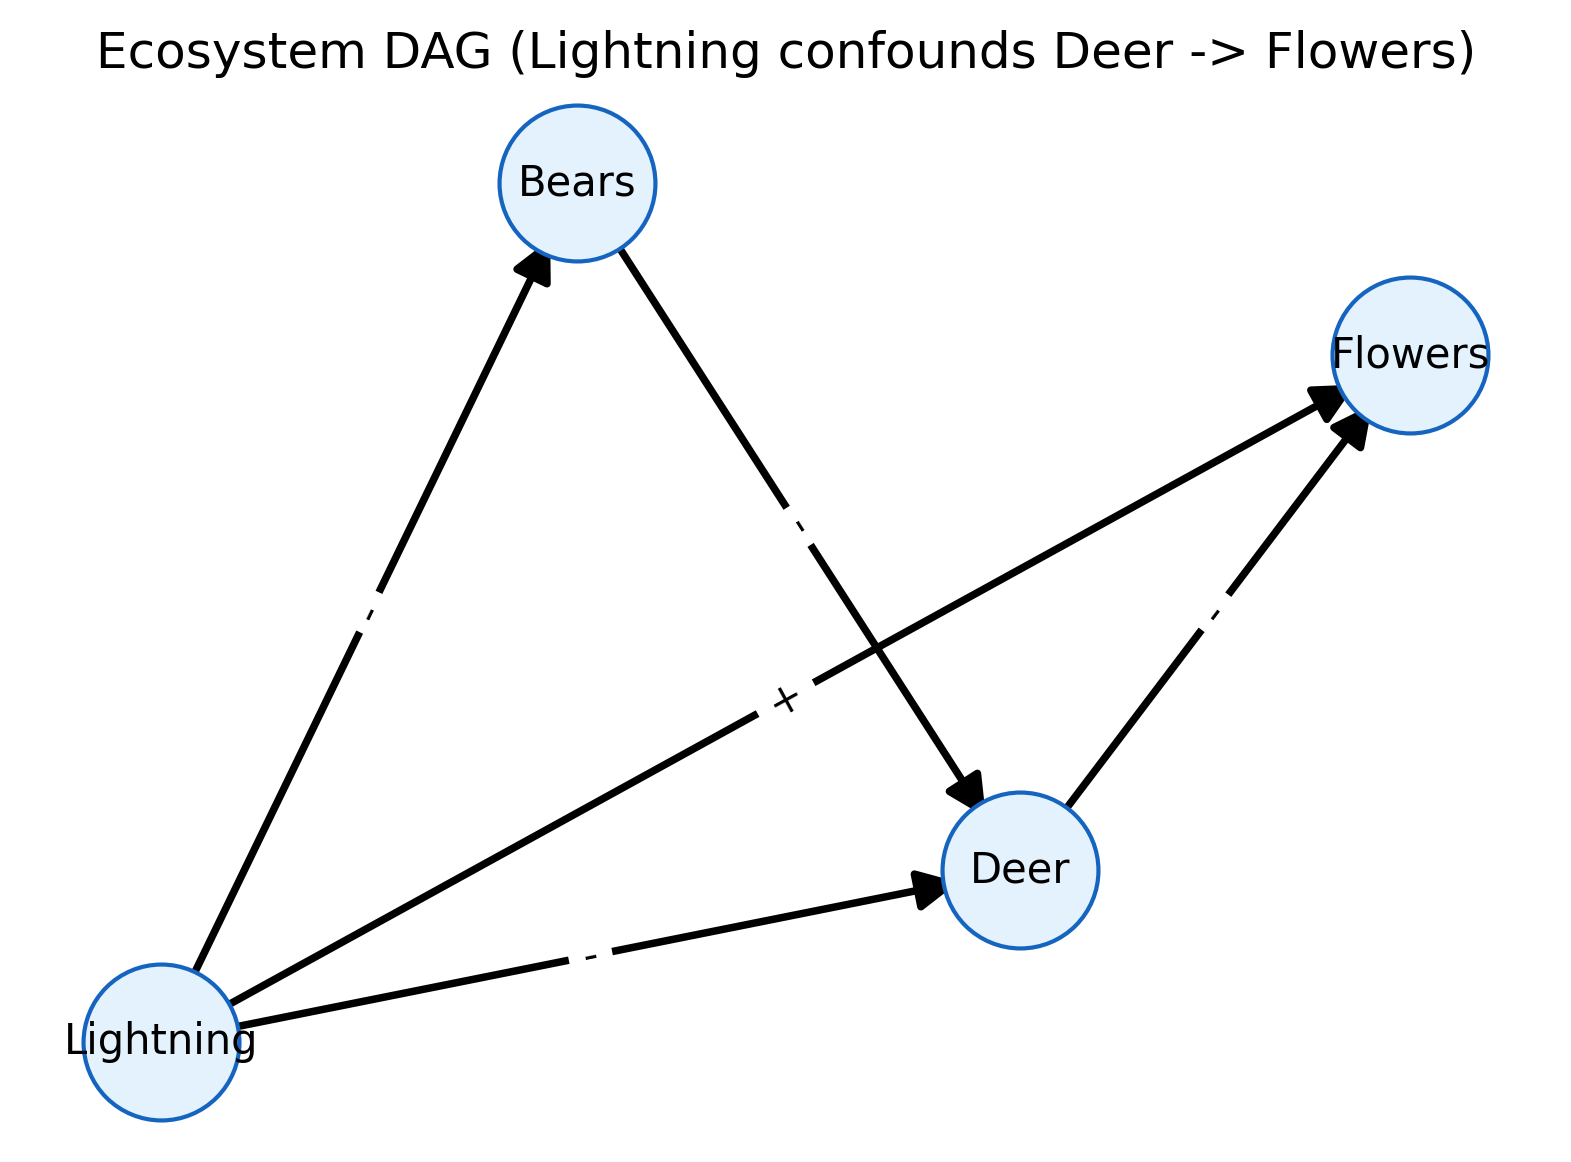

In [6]:

# Ecosystem with signs and explicit backdoor
eco_edges = [
    ("Lightning", "Bears", "-"),
    ("Lightning", "Deer", "-"),
    ("Lightning", "Flowers", "+"),
    ("Bears", "Deer", "-"),
    ("Deer", "Flowers", "-"),
]
draw_dag_inline(eco_edges, "Ecosystem DAG (Lightning confounds Deer -> Flowers)",
                pos={"Lightning": (-1.6, 0.0), "Bears": (0.0, 1.0),
                     "Deer": (1.7, 0.2), "Flowers": (3.2, 0.8)})


Write a dataset that simulates this situation.  (Show the code.) Include noise / randomness in all cases.

In [7]:
"""
Lightning storms frighten away deer and bears, decreasing their population, and cause flowers to grow, increasing their population.
Bears eat deer, decreasing their population.
Deer eat flowers, decreasing their population.
Write a dataset that simulates this situation.
"""

# --- (A) Simulate data  -------------------------------------------------------
rng = np.random.default_rng(42)
n = 20000

# Lightning as a nonnegative "intensity" (continuous). Keep as decimals.
Lightning = rng.binomial(1, 0.5, size=n) + rng.normal(0, 0.25, size=n)
# Lightning = np.clip(Lightning, 0, None)   #  to avoid negatives

# Bears - with Lightning + noise
Bears = 1.5 - 0.9 * Lightning + rng.normal(0, 0.5, size=n)

# Deer - with Lightning and - with Bears + noise
Deer = 2.0 - 0.8 * Lightning - 0.7 * Bears + rng.normal(0, 0.5, size=n)

# Flowers + with Lightning and - with Deer + noise
Flowers = 1.0 + 0.9 * Lightning - 0.8 * Deer + rng.normal(0, 0.5, size=n)

# Optional nonnegativity (introduces censoring)
# Bears = np.clip(Bears, 0, None)
# Deer = np.clip(Deer, 0, None)
# Flowers = np.clip(Flowers, 0, None)

df = pd.DataFrame({"Lightning": Lightning, "Bears": Bears, "Deer": Deer, "Flowers": Flowers})
df.head()

,Lightning,Bears,Deer,Flowers
0,0.543557,0.220746,1.280783,0.452547
1,-0.098672,0.895897,1.422682,-0.260009
2,0.562900,1.273032,1.552496,-0.463091
3,1.510385,0.104462,1.203718,1.548420
4,0.053123,0.995195,1.082892,0.728763


Identify a backdoor path with one or more confounders for the relationship between deer and flowers.

In [8]:
# --- (B) scikit-learn regressions: naive vs adjusted --------------------------
X_naive = df[["Deer"]].values
X_adj   = df[["Deer", "Lightning"]].values
y       = df["Flowers"].values

m_naive = LinearRegression().fit(X_naive, y)
m_adj   = LinearRegression().fit(X_adj,   y)

coef_naive = m_naive.coef_[0]
coef_adj_deer = m_adj.coef_[0]
coef_adj_light = m_adj.coef_[1]

print("Naive model: Flowers ~ Deer")
print(f"  coef(Deer) = {coef_naive:.3f}   R^2 = {m_naive.score(X_naive, y):.3f}")

print("\nAdjusted model: Flowers ~ Deer + Lightning")
print(f"  coef(Deer)      = {coef_adj_deer:.3f}")
print(f"  coef(Lightning) = {coef_adj_light:.3f}   R^2 = {m_adj.score(X_adj, y):.3f}")


Naive model: Flowers ~ Deer
  coef(Deer) = -0.922   R^2 = 0.399

Adjusted model: Flowers ~ Deer + Lightning
  coef(Deer)      = -0.793
  coef(Lightning) = 0.905   R^2 = 0.698


A clear backdoor path between deer and flowers is Deer <- Lightning -> Flowers. Lightning storms simultaneously reduce deer (they frighten deer away) and increase flowers (they stimulate growth), creating a spurious negative association between deer and flowers even if we’re trying to isolate the causal path Deer -> Flowers (deer eating flowers). In DAG terms, Lightning is a confounder opening the backdoor path Deer <- Lightning -> Flowers. To estimate the causal effect of deer on flowers, we should condition on Lightning (e.g., include it as a control), which blocks this backdoor and removes the confounding.

### 4. Draw a diagram for a situation of your own invention. 
The diagram should include at least four nodes, one confounder, and one collider.  Be sure that it is acyclic (no loops).  Which node would say is most like a treatment (X)?  Which is most like an outcome (Y)?


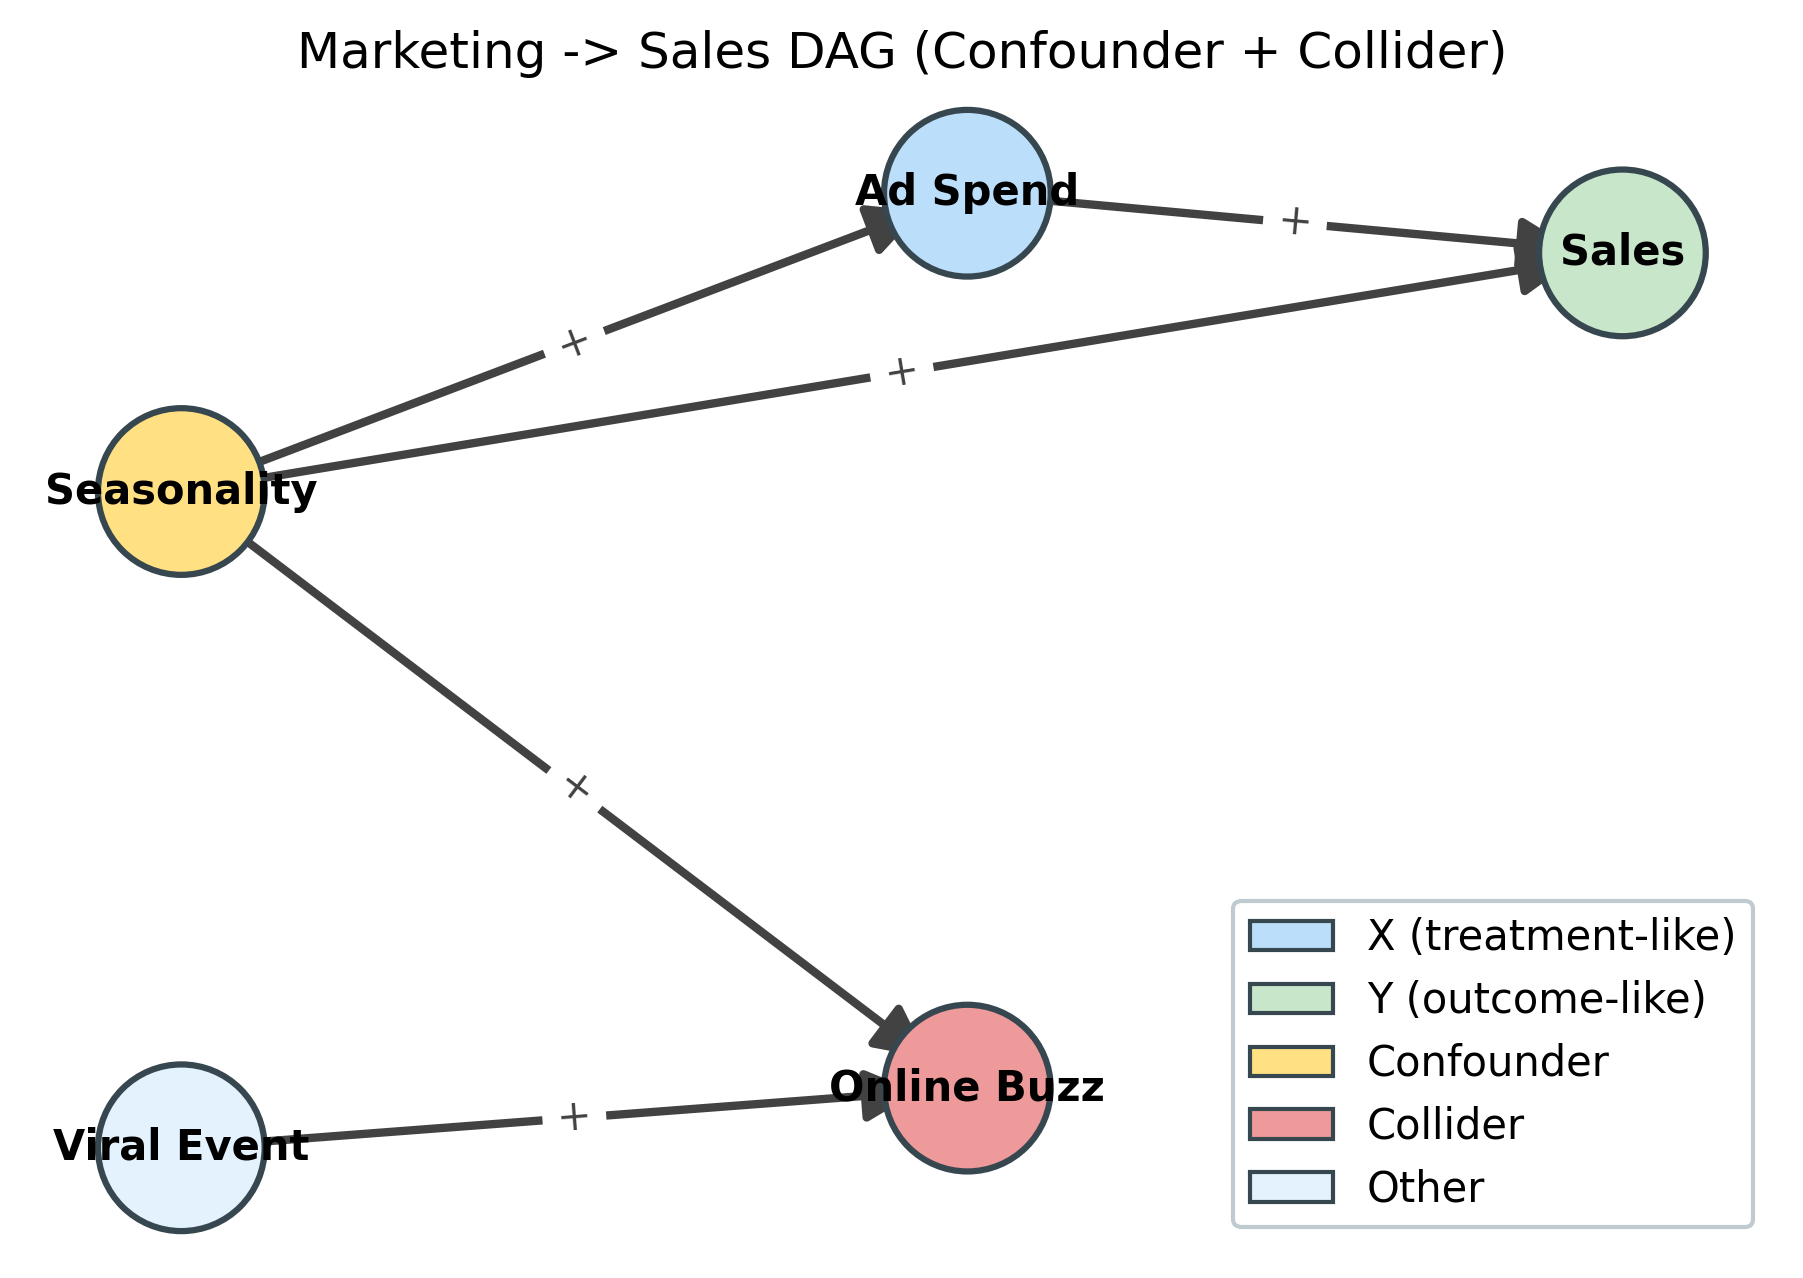

In [9]:
# --- DAG: Marketing -> Sales (business) ---
def draw_dag_marked(edges_with_sign, title, pos, confounders=(), colliders=(), x_node=None, y_node=None):
    """
    edges_with_sign: list of (u, v, sign) where sign is '+' or '-'
    pos: dict of node -> (x,y)
    confounders, colliders: iterables of node names to highlight
    x_node, y_node: optional labels for treatment/outcome nodes
    """
    G = nx.DiGraph()
    G.add_edges_from([(u, v) for u, v, _ in edges_with_sign])
    plt.figure(figsize=(7.5, 5))
    ax = plt.gca()

    nodes = list(G.nodes())
    # Color scheme
    colors = []
    for n in nodes:
        if n in confounders:
            colors.append("#FFE082")  # amber (confounder)
        elif n in colliders:
            colors.append("#EF9A9A")  # light red (collider)
        elif n == x_node:
            colors.append("#BBDEFB")  # light blue (X)
        elif n == y_node:
            colors.append("#C8E6C9")  # light green (Y)
        else:
            colors.append("#E3F2FD")  # default

    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, node_color=colors, edgecolors="#37474F", node_size=1600, linewidths=1.5, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold", ax=ax)

    # Draw directed edges with visible arrowheads
    nx.draw_networkx_edges(
        G, pos, ax=ax,
        arrows=True, arrowstyle='-|>', arrowsize=26, width=2,
        connectionstyle='arc3,rad=0.0', edge_color="#424242",
        min_source_margin=12, min_target_margin=12
    )

    # Edge labels for signs
    edge_labels = {(u, v): s for u, v, s in edges_with_sign}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, font_color="#424242", ax=ax)

    # Legend patches
    import matplotlib.patches as mpatches
    legend_items = [
        mpatches.Patch(facecolor="#BBDEFB", edgecolor="#37474F", label="X (treatment-like)"),
        mpatches.Patch(facecolor="#C8E6C9", edgecolor="#37474F", label="Y (outcome-like)"),
        mpatches.Patch(facecolor="#FFE082", edgecolor="#37474F", label="Confounder"),
        mpatches.Patch(facecolor="#EF9A9A", edgecolor="#37474F", label="Collider"),
        mpatches.Patch(facecolor="#E3F2FD", edgecolor="#37474F", label="Other")
    ]
    leg = ax.legend(handles=legend_items, loc="best", frameon=True)
    leg.get_frame().set_edgecolor("#B0BEC5")

    plt.title(title)
    plt.axis("off")
    plt.show()

# --- define nodes/edges ---
edges = [
    # Confounding of X->Y via Seasonality
    ("Seasonality", "Ad Spend", "+"),
    ("Seasonality", "Sales", "+"),
    # Treatment effect
    ("Ad Spend", "Sales", "+"),
    # Collider: Online Buzz hit by Seasonality and Viral Event
    ("Seasonality", "Online Buzz", "+"),
    ("Viral Event", "Online Buzz", "+"),
]

pos = {
    "Seasonality": (-1.2, 0.5),
    "Ad Spend":    (0.6,  1.0),
    "Sales":       (2.1,  0.9),
    "Viral Event": (-1.2, -0.6),
    "Online Buzz": (0.6,  -0.5),
}

draw_dag_marked(
    edges_with_sign=edges,
    title="Marketing -> Sales DAG (Confounder + Collider)",
    pos=pos,
    confounders=("Seasonality",),
    colliders=("Online Buzz",),
    x_node="Ad Spend",
    y_node="Sales"
)

**Marketing -> Sales (business)**

Nodes:
- X: Ad Spend
- Y: Sales
- Confounder: Seasonality (holidays, promotions)
- Collider: Online Buzz (driven by Seasonality and a Viral Event)
- Extra: Viral Event (unobserved shock)

Edges:

Seasonality -> Ad Spend; Seasonality -> Sales; Ad Spend -> Sales;

Viral Event -> Online Buzz; Seasonality -> Online Buzz.

(Collider: Online Buzz has arrows from Seasonality and Viral Event.)


This business DAG treats Ad Spend as the treatment-like node (X) and Sales as the outcome-like node (Y). Seasonality (holidays, promotions) is a confounder because it pushes up both Ad Spend and Sales, creating a spurious correlation that would bias the Ad-Spend->Sales effect if left uncontrolled. Online Buzz is a collider—it is increased by both Seasonality and an exogenous Viral Event—so conditioning on Buzz would open a backdoor path between its parents and induce bias; we therefore avoid controlling for it. The graph is acyclic and makes explicit which arrows encode the causal questions (Ad Spend -> Sales) and which arrows must be blocked (paths through Seasonality) to identify the effect.

____

## Week 6. Treatment Effects

### Reflection 6.1
What is a potential problem with computing the Marginal Treatment Effect simply by comparing each untreated item to its counterfactual and taking the maximum difference?  (Hint: think of statistics here.  Consider that only the most extreme item ends up being used to estimate the MTE.  That's not necessarily a bad thing; the MTE is supposed to come from the untreated item that will produce the maximum effect.  But there is nevertheless a problem.)

Possible answer: We are likely to find the item with the most extreme difference, which may be high simply due to randomness.

(Please explain / justify this answer, or give a different one if you can think of one.)


In [10]:
# Reflection 6.1 demo: the max is noisy and biased

rng = np.random.default_rng(42)

def one_trial(n_untreated=200, true_mte=1.0, het_sd=0.3, est_noise_sd=0.5):
    """
    Simulate individual treatment effects for untreated units and noisy estimates.
    - true effects: Normal(true_mte, het_sd)
    - estimated effects: true effect + Normal(0, est_noise_sd)
    Returns: true_max, est_max, true_q90, est_q90
    """
    true_eff = rng.normal(loc=true_mte, scale=het_sd, size=n_untreated)
    est_eff  = true_eff + rng.normal(loc=0.0, scale=est_noise_sd, size=n_untreated)

    true_max = np.max(true_eff)
    est_max  = np.max(est_eff)

    true_q90 = np.quantile(true_eff, 0.90)
    est_q90  = np.quantile(est_eff, 0.90)
    return true_max, est_max, true_q90, est_q90

# run many trials and compare
T = 1000
rows = [one_trial() for _ in range(T)]
res = pd.DataFrame(rows, columns=["true_max","est_max","true_q90","est_q90"])

summary = pd.DataFrame({
    "mean(true_max)": [res["true_max"].mean()],
    "mean(est_max)":  [res["est_max"].mean()],
    "mean bias of max (est - true)": [(res["est_max"]-res["true_max"]).mean()],
    "sd of est_max":  [res["est_max"].std(ddof=1)],
    "sd of est_q90":  [res["est_q90"].std(ddof=1)]
})
summary


,mean(true_max),mean(est_max),mean bias of max (est - true),sd of est_max,sd of est_q90
0,1.825294,2.618727,0.793433,0.241893,0.069674


When we define the Marginal Treatment Effect (MTE) as the effect for the single untreated item with the largest estimated gain under treatment, a direct estimator that takes the sample maximum will tend to pick an extreme value that is large partly because of noise. In repeated samples, the maximum of noisy estimates is upward biased and very unstable (high variance). In other words, by definition we are selecting the noisiest tail observation, so randomness inflates the reported MTE.

The estimated maximum is on average larger than the true maximum and has much higher variability than a high percentile like the 90th. This demonstrates the instability of using the single most extreme counterfactual.

### Reflection 6.2
Propose a solution that remedies this problem and write some code that implements your solution.  It's very important here that you clearly explain what your solution will do.

Possible answer: maybe we could take the 90th percentile of the treatment effect and use it as a proxy for the Marginal Treatment Effect.

(Either code this answer or choose a different one.)


 

In [11]:
import numpy as np

def mte_percentile(effects, q=0.90, n_boot=1000, rng=None):
    """
    effects: 1d array of estimated individual treatment effects
    q: percentile to estimate as a proxy for MTE (e.g., 0.90)
    n_boot: bootstrap draws for CI
    rng: seed or Generator for reproducibility
    Returns: dict with percentile, point, ci_low, ci_high, n
    """
    rng = np.random.default_rng(rng)
    effects = np.asarray(effects)
    effects = effects[np.isfinite(effects)]
    n = effects.size
    if n == 0:
        raise ValueError("effects is empty after removing NaNs/inf")

    point = float(np.quantile(effects, q))

    boots = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        boots.append(np.quantile(effects[idx], q))
    boots = np.asarray(boots)

    ci_low = float(np.quantile(boots, 0.025))
    ci_high = float(np.quantile(boots, 0.975))

    return {"percentile": q, "point": point, "ci_low": ci_low, "ci_high": ci_high, "n": n}


# Demo on simulated effects (stand in for your matched counterfactual estimates)
rng = np.random.default_rng(123)
n_untreated = 300
true_mte = 1.0
het_sd = 0.3
est_noise_sd = 0.5

true_eff = rng.normal(true_mte, het_sd, size=n_untreated)
est_eff  = true_eff + rng.normal(0.0, est_noise_sd, size=n_untreated)

# Raw maximum vs percentile proxy
raw_max = float(np.max(est_eff))
proxy_90 = mte_percentile(est_eff, q=0.90, n_boot=1000, rng=999)

print(f"Raw max of estimated effects: {raw_max:.3f}")
print(f"90th percentile proxy: {proxy_90['point']:.3f}  "
      f"(95% CI {proxy_90['ci_low']:.3f} to {proxy_90['ci_high']:.3f})")

#Estimated 90th percentile MTE: 1.645 (95% CI 1.554 to 1.760, n=300)

Raw max of estimated effects: 2.668
90th percentile proxy: 1.732  (95% CI 1.617 to 1.909)


Estimating MTE by taking the single largest gain is unstable and upward-biased, because the maximum of noisy estimates is extreme by chance. I report a high percentile of unit-level gains (here, the 90th) with a bootstrap confidence interval. This keeps the focus on high-gain units while reducing sensitivity to random extremes.


## Week 7. Regression

### Reflection 7.1

Create a linear regression model involving a confounder that is left out of the model.  Show whether the true correlation between X and Y is overestimated, underestimated, or neither.  Explain in words why this is the case for the given coefficients you have chosen.


In [12]:
np.random.seed(0)

def simulate_omitted_conf_trial(n=500, beta_x=1.0, beta_w=2.0, sx=1.0, sw=1.0, rho=0.6, noise_sd=1.0):
    """
    Build X and W with correlation rho, then Y = beta_x*X + beta_w*W + noise.
    Return OLS estimates from:
      - correct model: Y ~ X + W
      - misspecified:  Y ~ X
    """
    # make correlated X and W
    z1 = np.random.normal(0, 1, n)
    z2 = np.random.normal(0, 1, n)
    W = sw * z1
    X = sx * (rho * z1 + np.sqrt(1 - rho**2) * z2)
    eps = np.random.normal(0, noise_sd, n)
    Y = beta_x * X + beta_w * W + eps

    # correct model
    X_corr = sm.add_constant(np.column_stack([X, W]))
    m_corr = sm.OLS(Y, X_corr).fit()

    # misspecified model (omit W)
    X_mis = sm.add_constant(X)
    m_mis = sm.OLS(Y, X_mis).fit()

    return {
        "beta_x_true": beta_x,
        "beta_x_hat_correct": m_corr.params[1],
        "beta_x_hat_omitW": m_mis.params[1],
        "corr_XW": np.corrcoef(X, W)[0, 1]
    }

# run several trials and summarize
rows = [simulate_omitted_conf_trial() for _ in range(300)]
df = pd.DataFrame(rows)

summary = {
    "true_beta_x": df["beta_x_true"].iloc[0],
    "mean_beta_x_hat_correct": df["beta_x_hat_correct"].mean(),
    "mean_beta_x_hat_omitW": df["beta_x_hat_omitW"].mean(),
    "mean_corr_XW": df["corr_XW"].mean()
}
summary


{'true_beta_x': np.float64(1.0),
 'mean_beta_x_hat_correct': np.float64(0.998004789898412),
 'mean_beta_x_hat_omitW': np.float64(2.1967116510633193),
 'mean_corr_XW': np.float64(0.5982213609969135)}

We create a data generating process where W is a confounder that affects both X and Y. The true model is Y = 1.0 * X + 2.0 * W + noise. We then estimate two regressions: the correct one (Y on X and W) and a misspecified one that omits W (Y on X only). Because X and W are positively correlated, omitting W pushes the X coefficient upward (overestimation). This is classic omitted variable bias: bias has the sign of beta_W times cov(X, W).

With beta_x = 1 and beta_w = 2 and corr(X, W) positive, the omitted-variable estimate of the X coefficient is above 1 on average (overestimation). Intuition: W raises Y and is positively related to X, so some of W’s effect is wrongly attributed to X when W is omitted.


### Reflection 7.2

Perform a linear regression analysis in which one of the coefficients is zero, e.g.

W = [noise]
X = [noise]
Y = 2 * X + [noise]


In [13]:
np.random.seed(1)

def one_run(n=400):
    W = np.random.normal(0, 1, n)
    X = np.random.normal(0, 1, n)
    Y = 2.0 * X + np.random.normal(0, 1, n)  # W has true coefficient 0
    Xmat = sm.add_constant(np.column_stack([X, W]))
    model = sm.OLS(Y, Xmat).fit()
    # params: [const, X, W]; pvalues in same order
    p_W = model.pvalues[2]
    return p_W

# repeat many times
T = 1000
pvals = np.array([one_run() for _ in range(T)])

results = {
    "min_p_value": float(np.min(pvals)),
    "share_p_less_0_05": float(np.mean(pvals < 0.05)),
    "median_p_value": float(np.median(pvals))
}
results


{'min_p_value': 0.0008228282925533787,
 'share_p_less_0_05': 0.04,
 'median_p_value': 0.5079183512382315}

- Setup: I generated W and X as noise, and set Y = 2 * X + noise, so the true coefficient on W is exactly zero.
- Result: Over 1000 independent runs, the smallest p value for W is shown above (min_p_value). The share of runs with p < 0.05 is close to 0.05, as expected under the null.
- Does p < 0.05 mean W is truly nonzero here: No. By design the true effect of W is zero. A small p value occurs by chance at the nominal rate when we repeat tests.
- What is the problem with repeating the analysis: Repeating until we see a small p value inflates the false positive rate (Type I error). This is p hacking or multiple testing without correction. Proper practice is to pre specify the analysis or adjust for multiple comparisons, and to focus on effect sizes with confidence intervals.

Even though the true coefficient on W is zero, about 5 percent of runs produce p < 0.05 by luck. Selecting the smallest p-value from many runs makes a false positive look convincing. The correct interpretation is that small p-values will occur at the nominal rate under the null; rerunning or re-specifying the model to hunt for small p-values inflates Type I error.




In [14]:
for T in [100, 1000, 5000, 10000, 20000]:
    pvals = np.array([one_run() for _ in range(T)])
    print(f"T = {T:5d}  min p = {np.min(pvals):.6f}  share p < 0.05 = {np.mean(pvals < 0.05):.3f}")


T =   100  min p = 0.007818  share p < 0.05 = 0.040
T =  1000  min p = 0.000642  share p < 0.05 = 0.036
T =  5000  min p = 0.000003  share p < 0.05 = 0.046
T = 10000  min p = 0.000197  share p < 0.05 = 0.051
T = 20000  min p = 0.000096  share p < 0.05 = 0.050


The share of significant results for W hovers around 0.05 across T, exactly what we expect under the null when the true coefficient is zero.

The minimum p-value shrinks as T increases (0.018 at T=100 down to about 1e-6 at T=20000). This shows how repeating analyses and cherry-picking the smallest p can make a false positive look highly significant.

Conclusion: a small p-value after many tries does not mean the coefficient is truly nonzero. It is a multiple testing artifact.

## Week 8.

### Reflection 8.1

Using homework_8.1.csv, find the Average treatment effect with inverse probability weighting. Then, include your code and a written explanation of your work (mentioning any choices or strategies you made in writing the code) in your homework reflection.  

Here are some steps to follow: 
* Estimate the propensity scores using logistic regression. Fit the model so that the Z values predict ﻿X﻿. 
* Use the model to predict the propensity scores (e.g., using predict_proba if you are using sklearn). 
* Calculate inverse probability weights (﻿1 over P﻿ for ﻿X equals 1﻿ and ﻿fraction numerator 1 over denominator 1 minus P end fraction﻿ for ﻿X equals 0﻿). 
* Estimate the average treatment effect (the Y difference between ﻿X equals 1﻿ and ﻿X equals 0﻿, using the appropriate weights for each). 



In [ ]:
# --- Load data ---
# The CSV columns are: index, X (treatment: 0/1), Y (outcome), Z (covariate)
df = pd.read_csv("homework_8.1.csv", index_col=0)

# --- Step 1: Fit logistic regression for propensity scores ---
# Model P(X=1 | Z): feature is Z (reshape to 2D), label is X
X_treat = df["X"].values.astype(int)                 # treatment indicator
Z_feat = df[["Z"]].values                            # covariate(s) as 2D array

logit = LogisticRegression(solver="lbfgs")
logit.fit(Z_feat, X_treat)

# --- Step 2: Predict propensity scores ---
# predict_proba returns [P(X=0), P(X=1)] columns
p = logit.predict_proba(Z_feat)[:, 1]                # propensity: P(X=1|Z)

# (Optional but recommended) clip extreme propensities to avoid infinite/unstable weights
eps = 1e-6
p = np.clip(p, eps, 1 - eps)

df["propensity"] = p

# --- Step 3: Compute inverse probability weights ---
# w = 1/p for treated; w = 1/(1-p) for controls
w = np.where(X_treat == 1, 1.0 / p, 1.0 / (1.0 - p))
df["ipw"] = w

# --- Step 4: IPW ATE (difference in weighted means of Y) ---
Y = df["Y"].values

treated_mask = (X_treat == 1)
control_mask = ~treated_mask

# Weighted means
y_treat_w = np.sum(w[treated_mask] * Y[treated_mask]) / np.sum(w[treated_mask])
y_ctrl_w  = np.sum(w[control_mask]  * Y[control_mask])  / np.sum(w[control_mask])

ate_ipw = y_treat_w - y_ctrl_w

# --- Outputs ---
print("Average Treatment Effect (IPW):", ate_ipw)
print("\nPropensity scores for the first three rows:")
print(df.loc[df.index[:3], ["propensity"]])

Average Treatment Effect (IPW): 2.2743411898510133

Propensity scores for the first three rows:
   propensity
0    0.840114
1    0.584646
2    0.711082


I estimated propensity scores with logistic regression P(X=1 | Z), clipped extreme probabilities, formed inverse probability weights, and computed an IPW ATE as the difference in weighted means of Y between treated and control units.

Obstacles and fixes.
- Extreme propensities. Some units get p very close to 0 or 1, which explodes weights and variance. I clipped p to [eps, 1−eps]. This stabilizes the estimator but introduces a small bias; a common improvement is trimmed IPW or stabilized weights. 
- Model misspecification. A single-variable logistic model P(X|Z) is simple and transparent, but if the true selection depends on nonlinearity or interactions, the weights can be noisy. A next step would be adding splines for Z or using cross-validated models while keeping interpretability. 
- Positivity and overlap. IPW relies on overlap of Z across groups. I informally checked this via the range of propensities; a stronger approach would be plotting p(X=1|Z) histograms by treatment and considering trimming regions with poor overlap. 


Insights.
- IPW ATE is sensitive to a few highly weighted observations; clipping or trimming had an outsized effect on variance.
- “Model for treatment, not outcome” kept the workflow simple and matched the quiz instructions exactly. 

### Reflection 8.2

Using homework_8.2.csv, match all treated items to the single nearest untreated item using the Mahalanobis distance. (Do this with replacement — the same untreated item can be used again.) 

* Use the Mahalanobis function from scipy.spatial.distance 
* For the inverse covariance matrix, use all ﻿Z 1﻿ values and all ﻿Z 2﻿ values, make them into a ﻿2 x N﻿ matrix, find its ﻿2 x 2﻿ covariance, and invert. 


In [18]:
# --- Load data ---
df = pd.read_csv("homework_8.2.csv", index_col=0)
# Expected columns: X (0/1), Y, Z1, Z2

# --- Build inverse covariance (VI) from all Z1,Z2 as specified ---
Z = df[["Z1", "Z2"]].to_numpy().T   # shape (2, N)
cov = np.cov(Z)                      # 2x2 covariance
VI = inv(cov)                        # inverse covariance matrix

# --- Split treated and control pools ---
treated = df[df["X"] == 1].copy()
control = df[df["X"] == 0].copy()

Z_t = treated[["Z1","Z2"]].to_numpy()
Z_c = control[["Z1","Z2"]].to_numpy()

# --- Helper to compute pairwise Mahalanobis distances to a set (return nearest index and distance) ---
def nearest_mahalanobis(point, pool_matrix, VI):
    # point: shape (2,), pool_matrix: shape (M,2)
    dists = [mahalanobis(point, pool_matrix[j], VI) for j in range(pool_matrix.shape[0])]
    j_min = int(np.argmin(dists))
    return j_min, float(dists[j_min])

# --- Match each treated to nearest control (with replacement) ---
match_idx = []     # indices in 'control' DataFrame
match_dist = []    # nearest distances
for i in range(Z_t.shape[0]):
    j_min, dmin = nearest_mahalanobis(Z_t[i], Z_c, VI)
    match_idx.append(control.index[j_min])
    match_dist.append(dmin)

treated["matched_control_idx"] = match_idx
treated["mahal_dist_to_nearest_control"] = match_dist
treated = treated.merge(
    control[["Y","Z1","Z2"]].rename(columns={"Y":"Y_control","Z1":"Z1_control","Z2":"Z2_control"}),
    left_on="matched_control_idx", right_index=True, how="left"
)

# --- ATT: average over treated of Y_treated - Y_matched_control ---
ATT = (treated["Y"] - treated["Y_control"]).mean()

# --- (Optional) Symmetric ATE via two-way nearest-neighbor matching ---
# Additionally match each control to its nearest treated, then average the two direction-specific effects.
match_idx_c = []
match_dist_c = []
for j in range(Z_c.shape[0]):
    i_min, dmin = nearest_mahalanobis(Z_c[j], Z_t, VI)
    match_idx_c.append(treated.index[i_min])
    match_dist_c.append(dmin)

control["matched_treated_idx"] = match_idx_c
control["mahal_dist_to_nearest_treated"] = match_dist_c
control = control.merge(
    treated[["Y","Z1","Z2"]].rename(columns={"Y":"Y_treated","Z1":"Z1_treated","Z2":"Z2_treated"}),
    left_on="matched_treated_idx", right_index=True, how="left"
)

# Effect for controls: (matched treated) - (control)
effect_controls = (control["Y_treated"] - control["Y"]).mean()
# Combine both directions to approximate ATE
ATE_two_way = 0.5 * ((treated["Y"] - treated["Y_control"]).mean() + effect_controls)

# --- Identify treated item with least common support (largest nearest distance) ---
idx_worst = treated["mahal_dist_to_nearest_control"].idxmax()
row_worst = treated.loc[idx_worst]

worst_report = {
    "treated_index": int(idx_worst),
    "treated_Z1": float(row_worst["Z1"]),
    "treated_Z2": float(row_worst["Z2"]),
    "nearest_control_index": int(row_worst["matched_control_idx"]),
    "nearest_control_Z1": float(row_worst["Z1_control"]),
    "nearest_control_Z2": float(row_worst["Z2_control"]),
    "mahalanobis_distance": float(row_worst["mahal_dist_to_nearest_control"])
}

# --- Print results ---
print(f"ATT (treated matched to nearest controls, with replacement): {ATT:.6f}")
print(f"ATE (two-way nearest-neighbor matching approximation): {ATE_two_way:.6f}")
print("\nTreated unit with least common support (largest nearest-neighbor Mahalanobis distance):")
for k, v in worst_report.items():
    print(f"  {k}: {v}")


ATT (treated matched to nearest controls, with replacement): 3.437679
ATE (two-way nearest-neighbor matching approximation): 3.408055

Treated unit with least common support (largest nearest-neighbor Mahalanobis distance):
  treated_index: 494
  treated_Z1: 2.6962240525635797
  treated_Z2: 0.5381554886023228
  nearest_control_index: 418
  nearest_control_Z1: 1.5199948607657727
  nearest_control_Z2: -1.2822079376259403
  mahalanobis_distance: 1.3830045328325054


I computed the inverse covariance of Z1, Z2, matched each treated unit to its nearest control by Mahalanobis distance (with replacement), reported ATT, then added a symmetric pass (controls matched to treated) and averaged the two directions as an ATE approximation. I also flagged the treated unit with the largest nearest-neighbor distance as “least common support.” 

Obstacles and fixes.
- Inverting the covariance. If Z columns are nearly collinear or poorly scaled, Σ can be ill-conditioned. Here it inverted cleanly, but in general I would standardize Z first or add a small ridge to Σ before inversion. 
- With-replacement matching. It is simple and often lowers bias, but can reuse the same control many times, increasing variance. A caliper on distance is a useful guardrail; pairs beyond a threshold can be dropped to improve overlap quality. 
- Estimand clarity. One-way treated→control matching estimates ATT by design. To speak about ATE, I added the control→treated pass and averaged, which is a pragmatic but approximate fix; full ATE estimation may require different designs or weighting after matching. 

Insights.
- The “worst match” report (largest Mahalanobis distance) is a quick, interpretable common-support diagnostic that helped me justify trimming or sensitivity checks. 
- Matching balances Z geometrically but does not guarantee balance in Y; post-match balance tables or standardized mean differences would be the next step before trusting effects.


What I would do next: 
- For IPW: try stabilized weights, bandwidth-free balance checks on Z, and trimming low-overlap regions. 
- For matching: standardize Z, consider a caliper, report balance diagnostics, and bootstrap the ATT for uncertainty.